In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

import datetime
from ngram import *
from baselines import *
from stats_utils import get_beta_dist, bayesian_ci
from error_analysis import *
import os
import fnmatch
import numpy as np
import time
import multiprocessing as mp

# Load Diffs and Models

### Load Models

In [2]:
m_agg = joblib.load( '../../models/aggression_ngram.pkl')
m_rec = joblib.load( '../../models/recipient_ngram.pkl')

def pred_helper(df):
    df['pred_aggression'] =  m_agg.predict(df['clean_diff']) * -1
    df['pred_recipient'] =  m_rec.predict(df['clean_diff'])
    df['pred_recipient_score'] =  get_scores(m_rec, df['clean_diff'])
    return df
    
def predict_in_parallel(df, k = 8):
    df['key'] = np.random.randint(0, high=5*k, size=df.shape[0])
    dfs = [e[1] for e in df.groupby('key')]
    t1 = time.time()
    p = mp.Pool(k)
    dfs = p.map(pred_helper, dfs)
    t2 = time.time()
    print(t2-t1)
    return pd.concat(dfs)

def prep_data(df, m_rec, m_agg , extra_cols = []):
    try:
        df['rev_timestamp'] = df['rev_timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%dT%H:%M:%SZ"))
    except:
        df['rev_timestamp'] = df['rev_timestamp'].apply(lambda x: datetime.datetime.strptime (x,"%Y-%m-%d %H:%M:%S")) 
    df = predict_in_parallel(df, k = 8)
    cols = ['rev_timestamp', 'pred_aggression', 'pred_recipient', 'pred_recipient_score', 'page_title', 'user_text','user_id']
    return df [cols + extra_cols]

### Load annotationed diffs

In [6]:
data_filename  = '../../data/v4_annotated/annotated_random_data_rows_0_to_5000_raters_20.csv'
d_annotations = tidy_labels(load_cf_labels(data_filename))

d_annotated = d_annotations.drop_duplicates(subset=['rev_id'])
d_annotated['aggression'] = average(d_annotations['aggression_score'].dropna()) * -1
d_annotated['recipiennumpy.random.randint(low, high=None, size=None)t'] = plurality(d_annotations['recipient'].dropna())
d_annotated['recipient_score'] = average(d_annotations['recipient'].dropna())

extra_cols = ['aggression','recipient', 'recipient_score' ]
d_annotated = prep_data(d_annotated, m_rec, m_agg, extra_cols = extra_cols)

5.166838884353638


### Load random sample of diffs

In [7]:
df_rand = pd.read_csv('../../data/v4/500k_random_sample.tsv', sep = '\t')
df_rand = prep_data(df_rand, m_rec, m_agg)

191.97843384742737


### Load all 2015 diffs

In [12]:
matches = []
for root, dirnames, filenames in os.walk('../../data/clean_user_talk_diff_tsv_no_admin'):
    for filename in fnmatch.filter(filenames, '2015*.tsv'):
        matches.append(os.path.join(root, filename))

df_2015 = pd.concat([pd.read_csv(f, sep = '\t') for f in matches])
df_2015 = prep_data(df_2015, m_rec, m_agg)

1532.105222940445


### Load all blocked user diffs

In [4]:
df_block = pd.read_csv('../../data/v4/all_blocked_user.tsv', sep = '\t')
df_block = prep_data(df_block, m_rec, m_agg)

538.2557549476624


### Load block events

In [9]:
df_events = pd.read_csv('../../data/v4/block_events.tsv', sep = '\t')

# Short Cut: Save/Load Above Computation

In [11]:
d_annotated.to_csv('d_annotated.tsv', sep = '\t')
df_rand.to_csv('df_rand.tsv', sep = '\t')
df_2015.to_csv('df_2015.tsv', sep = '\t')
df_block.to_csv('df_block.tsv', sep = '\t')
df_events.to_csv('df_events.tsv', sep = '\t')

In [ ]:
d_annotated = pd.read_csv('d_annotated.tsv', sep = '\t')
df_rand = pd.read_csv('df_rand.tsv', sep = '\t')
df_2015 = pd.read_csv('df_2015.tsv', sep = '\t')
df_events = pd.read_csv('df_events.tsv', sep = '\t')

# Simple Summary Stats

## Question: What fraction of comments are personal attacks?
Methodology: Compute credible interval for probability that a comment is an attack over random or full sample of data.

In [10]:
# annotators
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % bayesian_ci(get_beta_dist(d_annotated['recipient'].sum(), d_annotated.shape[0]), 95)

'Fraction of comments labeled as attacks: (0.007, 0.012)'

In [11]:
# model on annotator data Note: this is currently not kosher since the model was trained on this data
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % bayesian_ci(get_beta_dist(d_annotated['pred_recipient'].sum(), d_annotated.shape[0]), 95)

'Fraction of comments labeled as attacks: (0.007, 0.012)'

In [13]:
# model on random data
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % bayesian_ci(get_beta_dist(df['pred_recipient'].sum(), df.shape[0]), 95)

'Fraction of comments labeled as attacks: (0.007, 0.008)'

In [ ]:
# model on full data
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % bayesian_ci(get_beta_dist(df['pred_recipient'].sum(), df.shape[0]), 95)

## Agression Hist

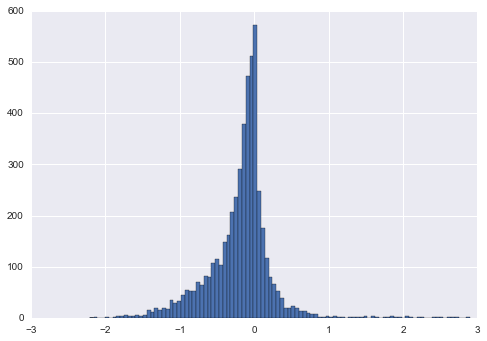

In [38]:
d_annotated['aggression'].hist(bins = 100)

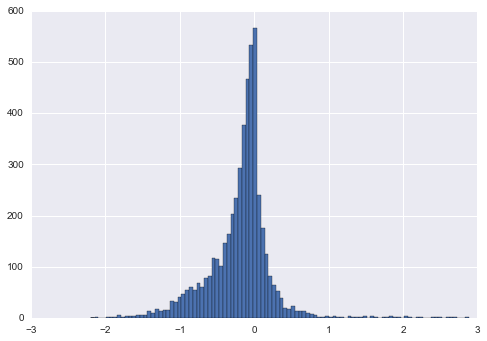

In [39]:
d_annotated['pred_aggression'].hist(bins = 100)

(-3, 3)

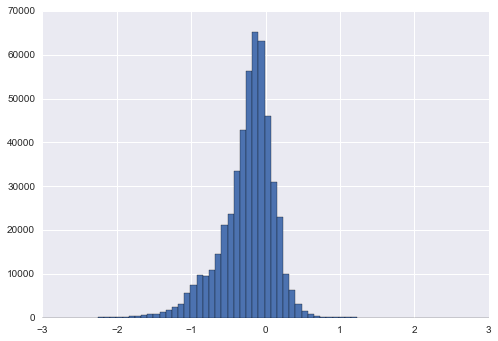

In [40]:
df['pred_aggression'].hist(bins = 100)
plt.xlim(-3, 3)

# Correlation between Agression and Attack

In [41]:
d_temp = d_annotated.dropna(subset=['aggression', 'recipient_score'])
pearson(d_temp['aggression'],d_temp['recipient_score'])

0.56260665280407618

In [42]:
d_temp = d_annotated.dropna(subset=['pred_aggression', 'pred_recipient_score'])
pearson(d_temp['pred_aggression'],d_temp['pred_recipient_score'])

0.46236138622469863

In [43]:
pearson(df['pred_aggression'],df['pred_recipient_score'])

0.3550929283050196

Hmm, this is pretty different from the annotatotr data

# Some plotting Utils

In [120]:
def mpg(df, score, cols):
    """
    return row with max score in each group of cols values
    """
    return df.sort(score, ascending=False).groupby(cols, as_index=False).first()

def plot_scores(df, x, mpu = False, order = None):
    
    if mpu:
        cols = ['user_text', x]
        plt.figure()
        ax = sns.pointplot(x=x, y= 'pred_aggression', data=mpg(df, 'pred_aggression', cols) , order = o)
        plt.figure()
        ax = sns.pointplot(x=x, y= 'pred_recipient', data=mpg(df, 'pred_recipient', cols) , order = o)
    else:
        plt.figure()
        ax = sns.pointplot(x=x, y= 'pred_aggression', data=df, order = o)
        plt.figure()
        ax = sns.pointplot(x=x, y= 'pred_recipient', data=df, order = o)
    
    

# Annon vs Registered User

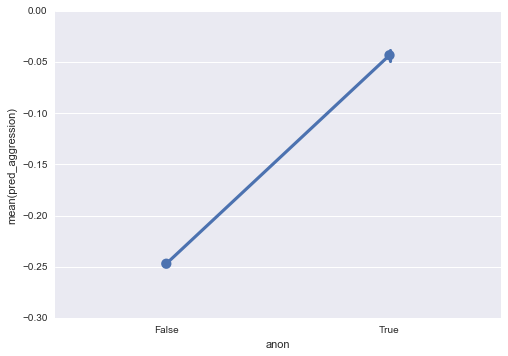

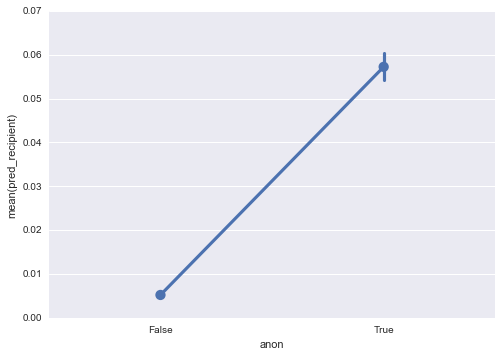

In [124]:
x = 'anon'
df [x] = df['user_id'].isnull()
o = (False, True)
plot_scores(df, x, order = o)

# Own page vs. other page

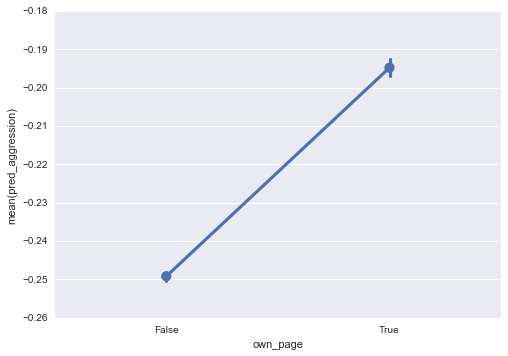

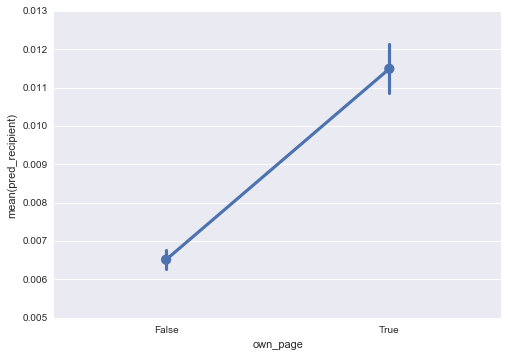

In [125]:
x = 'own_page'
df [x] = df['user_text'] == df['page_title']
o = (False, True)
plot_scores(df, x, order = o)

# Registered Users Own page vs. other page

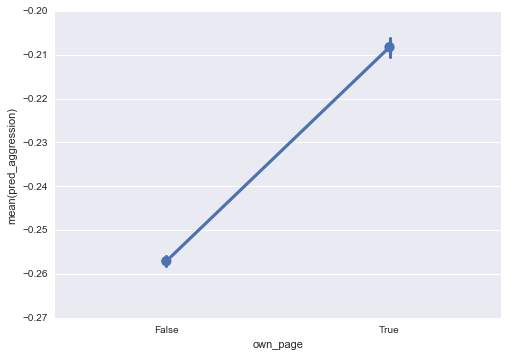

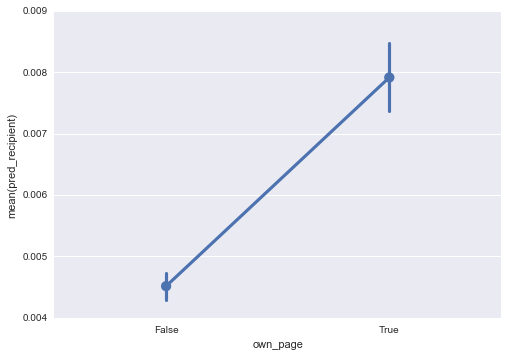

In [126]:
df_registered = df.query('not anon')
x = 'own_page'
o = (False, True)
plot_scores(df_registered, x, order = o)

# Patterns Over Time

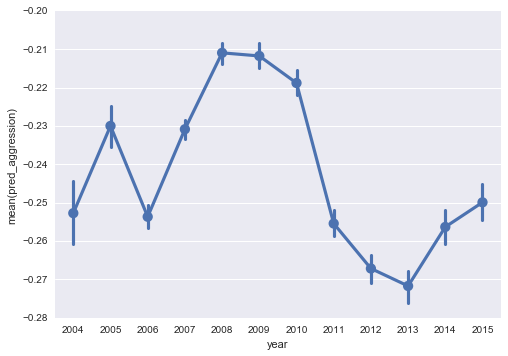

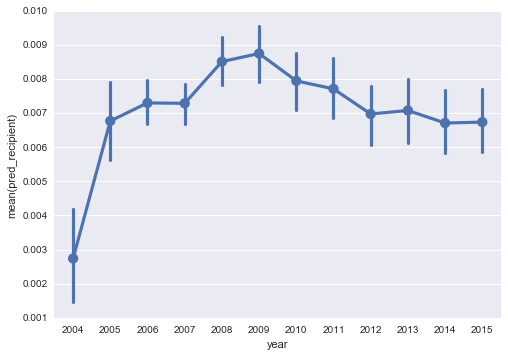

In [132]:
df['year'] = df['rev_timestamp'].apply(lambda x: x.year)
df_span = df.query('year > 2003 & year < 2016')
x = 'year'
o = range(2004, 2016)
plot_scores(df_span, x, order = o)

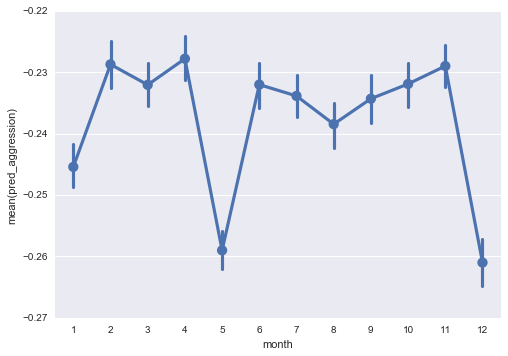

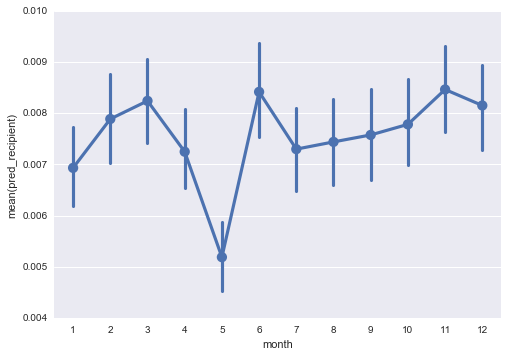

In [134]:
x = 'month'
df[x] = df['rev_timestamp'].apply(lambda x: x.month)
o = range(1, 13)
plot_scores(df, x, order = o)

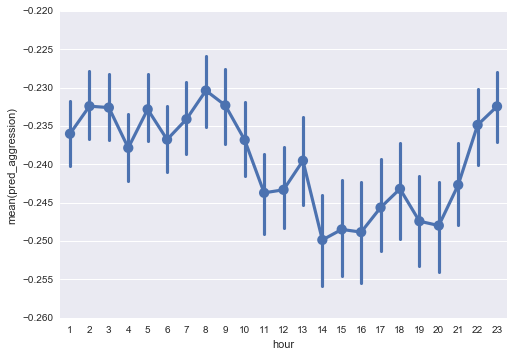

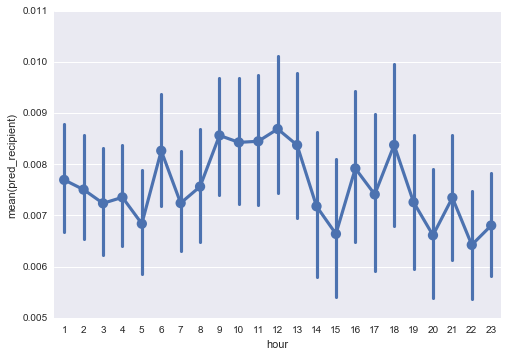

In [136]:
x = 'hour'
df[x] = df['rev_timestamp'].apply(lambda x: (x.hour + 8) % 24)
o  = range(1, 24)
plot_scores(df, x, order = o)